In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import sys
import os

# Add project root to path to import custom modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.models.cnn_lstm_with_attention import CNNLSTMWithAttention

plt.style.use('seaborn-v0_8-darkgrid')

# Load the dataset
file_path = '../data/processed/btc_with_indicators.csv'
df = pd.read_csv(file_path, parse_dates=['date'])
df.set_index('date', inplace=True)

print('Dataset loaded successfully.')
df.head()

Dataset loaded successfully.


,open,high,low,close,volume,symbol,source,download_timestamp_market,asset,adractcnt,...,txcnt,download_timestamp_onchain,sma_20,ema_20,rsi_14,macd,macd_signal,bb_upper,bb_lower,bb_width
date,,,,,,,,,,,,,,,,,,,,,
2024-08-17,58888.99,59711.02,58803.45,59497.49,2787.563556,BTC,alpha_vantage,2025-06-29 17:05:03.299936,btc,612305,...,706066,2025-06-29 17:05:04.117435,60254.8035,60403.007031,45.622968,-1471.243728,-1648.752168,67018.988212,53490.618788,13528.369424
2024-08-18,59497.49,60284.99,58422.00,58437.90,4325.648172,BTC,alpha_vantage,2025-06-29 17:05:03.299936,btc,588717,...,758170,2025-06-29 17:05:04.117435,59838.1260,60215.853981,43.087997,-1448.294115,-1608.660557,65939.486964,53736.765036,12202.721927
2024-08-19,58436.20,59639.81,57820.00,59452.67,8539.293787,BTC,alpha_vantage,2025-06-29 17:05:03.299936,btc,687027,...,560243,2025-06-29 17:05:04.117435,59502.2755,60143.169792,46.172655,-1332.858559,-1553.500158,64867.666765,54136.884235,10730.782531
2024-08-20,59455.81,61457.03,58571.96,59017.59,11062.052799,BTC,alpha_vantage,2025-06-29 17:05:03.299936,btc,696903,...,715687,2025-06-29 17:05:04.117435,59222.6740,60035.971717,45.045355,-1261.935562,-1495.187238,64050.168782,54395.179218,9654.989565
2024-08-21,59017.59,61849.98,58793.89,61163.28,13380.111017,BTC,alpha_vantage,2025-06-29 17:05:03.299936,btc,711700,...,684872,2025-06-29 17:05:04.117435,59016.4290,60143.334410,51.353332,-1020.821925,-1400.314176,63082.099375,54950.758625,8131.340750


In [2]:
# Define features and target
feature_cols = [
    'open', 'high', 'low', 'close', 'volume', # Market
    'adractcnt', 'txcnt', 'feetotntv',      # On-chain
    'sma_20', 'ema_20', 'rsi_14', 'macd', 'macd_signal', 'bb_upper', 'bb_lower', 'bb_width' # Indicators
]
target_col = 'close'

# Normalize the data
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

# Create sequences
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[feature_cols].iloc[i:i + window_size].values)
        y.append(data[target_col].iloc[i + window_size])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(df_scaled, window_size)

# Split data (70% train, 15% val, 15% test)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (200, 30, 16)
y_train shape: (200,)
X_val shape: (42, 30, 16)
X_test shape: (44, 30, 16)


In [3]:
# Convert to PyTorch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1) # Reshape y_train to be 2D (batch_size, 1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoaders
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [26]:
from datetime import datetime 

def train_cnn_lstm_attention(model, train_loader, val_loader, num_epochs=100, 
                           learning_rate=0.001, patience=10, save_dir='models'):
    """
    Complete training function with all enhancements
    """
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)
    
    # Training setup
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7
    )
    
    # Early stopping setup
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Tracking
    train_losses = []
    val_losses = []
    learning_rates = []
    
    print(f"Starting training at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print("-" * 70)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        num_batches = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass with gradient clipping
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            num_batches += 1
        
        train_loss = running_loss / num_batches
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        num_val_batches = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                running_val_loss += loss.item()
                num_val_batches += 1
        
        val_loss = running_val_loss / num_val_batches
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        # Print progress
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            print(f'Epoch [{epoch+1:3d}/{num_epochs}] | '
                  f'Train Loss: {train_loss:.6f} | '
                  f'Val Loss: {val_loss:.6f} | '
                  f'LR: {current_lr:.2e}')
        
        # Early stopping and model checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            
            # Save best model
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'best_val_loss': best_val_loss
            }
            torch.save(checkpoint, os.path.join(save_dir, 'best_model_checkpoint.pth'))
            
            if epoch > 10:  # Only print after some initial training
                print(f'    ✓ New best model saved! Val Loss: {val_loss:.6f}')
        else:
            patience_counter += 1
        
        # Early stopping check
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered at epoch {epoch+1}')
            print(f'Best validation loss: {best_val_loss:.6f}')
            break
        
        # Stop if learning rate becomes too small
        if current_lr < 1e-7:
            print(f'\nStopping: Learning rate too small ({current_lr:.2e})')
            break
    
    print("-" * 70)
    print(f"Training completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Best validation loss: {best_val_loss:.6f}")
    
    # Load best model
    best_checkpoint = torch.load(os.path.join(save_dir, 'best_model_checkpoint.pth'))
    model.load_state_dict(best_checkpoint['model_state_dict'])
    
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'learning_rates': learning_rates,
        'best_val_loss': best_val_loss,
        'best_epoch': best_checkpoint['epoch']
    }


In [ ]:

def plot_training_history(results, save_path=None):
    """
    Plot training history with losses and learning rate
    """
    _, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot losses
    epochs = range(1, len(results['train_losses']) + 1)
    ax1.plot(epochs, results['train_losses'], 'b-', label='Training Loss', alpha=0.8)
    ax1.plot(epochs, results['val_losses'], 'r-', label='Validation Loss', alpha=0.8)
    ax1.axhline(y=results['best_val_loss'], color='r', linestyle='--', alpha=0.7, 
                label=f'Best Val Loss: {results["best_val_loss"]:.6f}')
    ax1.axvline(x=results['best_epoch']+1, color='g', linestyle='--', alpha=0.7,
                label=f'Best Epoch: {results["best_epoch"]+1}')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # Plot learning rate
    ax2.plot(epochs, results['learning_rates'], 'g-', alpha=0.8)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('Learning Rate Schedule')
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training history plot saved to: {save_path}")
    
    plt.show()


In [28]:

def analyze_attention_weights(model, data_loader, feature_names=None, num_samples=5):
    """
    Analyze and visualize attention weights from the trained model
    """
    model.eval()
    feature_attentions = []
    temporal_attentions = []
    
    with torch.no_grad():
        sample_count = 0
        for batch_X, _ in data_loader:
            if sample_count >= num_samples:
                break
                
            # Get attention weights
            _, attention_weights = model(batch_X, return_attention_weights=True)
            
            if 'feature_attention' in attention_weights:
                feature_attentions.append(attention_weights['feature_attention'].cpu().numpy())
            
            if 'temporal_attention' in attention_weights:
                temporal_attentions.append(attention_weights['temporal_attention'].cpu().numpy())
            
            sample_count += 1
    
    # Plot feature attention
    if feature_attentions:
        avg_feature_attention = np.mean(np.vstack(feature_attentions), axis=0)
        
        plt.figure(figsize=(12, 6))
        bars = plt.bar(range(len(avg_feature_attention)), avg_feature_attention)
        plt.xlabel('Features')
        plt.ylabel('Attention Weight')
        plt.title('Average Feature Attention Weights')
        
        if feature_names:
            plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
        
        # Highlight top features
        top_features = np.argsort(avg_feature_attention)[-5:]
        for i in top_features:
            bars[i].set_color('red')
            bars[i].set_alpha(0.8)
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("Top 5 most important features:")
        if feature_names:
            for i, idx in enumerate(top_features[::-1]):
                print(f"{i+1}. {feature_names[idx]}: {avg_feature_attention[idx]:.4f}")
        else:
            for i, idx in enumerate(top_features[::-1]):
                print(f"{i+1}. Feature {idx}: {avg_feature_attention[idx]:.4f}")



/Users/komronvalijonov/work/personal/uni-research/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Model created with 16 features
Total parameters: 178,905
Starting training at 2025-06-29 22:05:31
Model parameters: 178,905
----------------------------------------------------------------------
Epoch [  1/100] | Train Loss: 0.257790 | Val Loss: 0.312977 | LR: 1.00e-03
Epoch [  6/100] | Train Loss: 0.012517 | Val Loss: 0.062124 | LR: 1.00e-03
Epoch [ 11/100] | Train Loss: 0.005503 | Val Loss: 0.020326 | LR: 1.00e-03
    ✓ New best model saved! Val Loss: 0.011589
    ✓ New best model saved! Val Loss: 0.010572
Epoch [ 16/100] | Train Loss: 0.007202 | Val Loss: 0.013170 | LR: 1.00e-03
    ✓ New best model saved! Val Loss: 0.008020
Epoch [ 21/100] | Train Loss: 0.010160 | Val Loss: 0.016452 | LR: 1.00e-03
    ✓ New best model saved! Val Loss: 0.006593
Epoch [ 26/100] | Train Loss: 0.005801 | Val Loss: 0.011931 | LR: 5.00e-04
Epoch [ 31/100] | Train Loss: 0.005212 | Val Loss: 0.009720 | LR: 2.50e-04

Early stopping triggered at epoch 32
Best validation loss: 0.006593
-----------------------

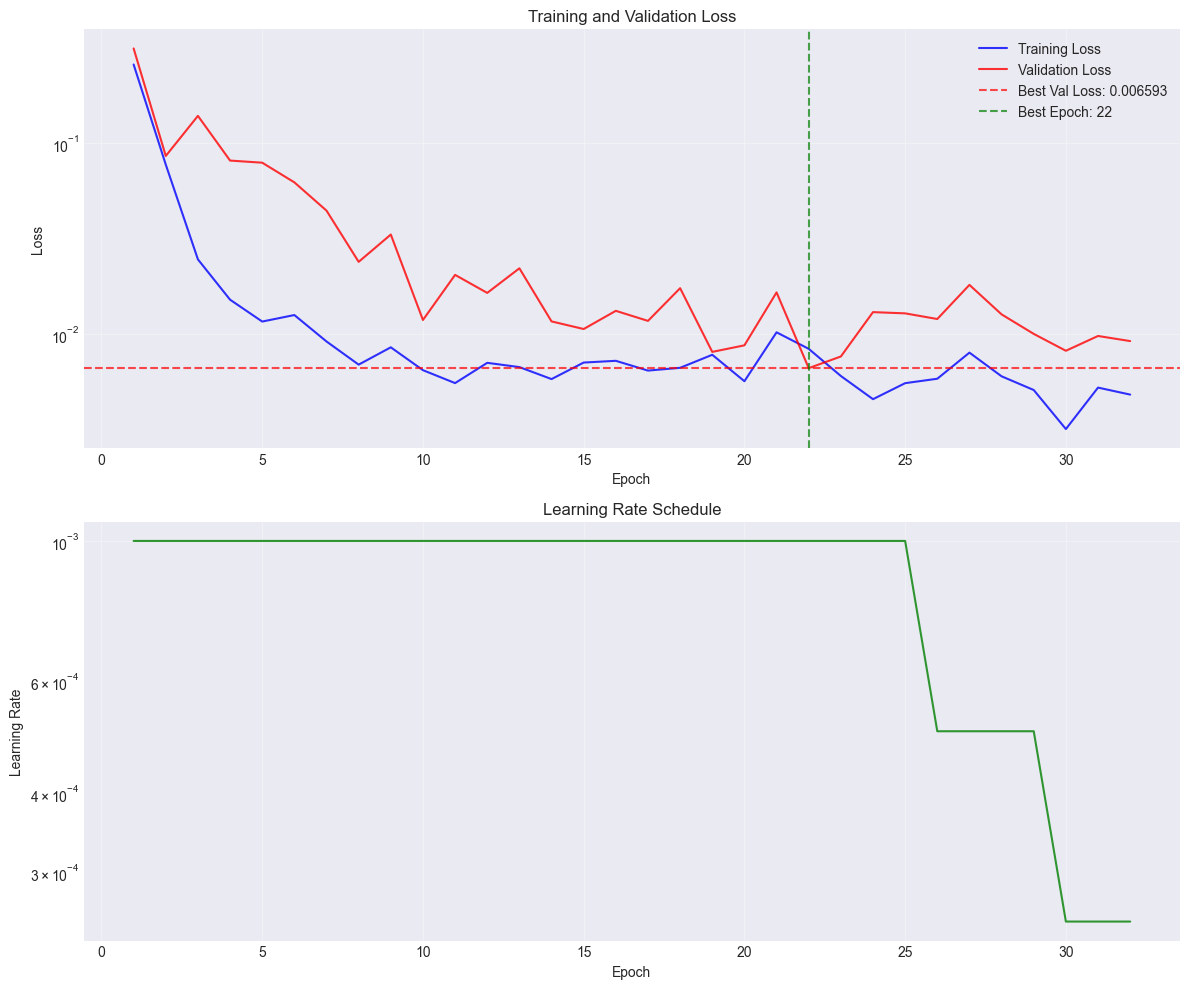


Training completed successfully!
Best model saved in: bitcoin_models/best_model_checkpoint.pth
Final validation loss: 0.006593


In [29]:
 # Model parameters
num_features = len(feature_cols)  # Make sure feature_cols is defined

# Create model
model = CNNLSTMWithAttention(
    num_features=num_features, 
    attention_heads=8, 
    use_feature_attention=True, 
    use_temporal_attention=True
)

print(f"Model created with {num_features} features")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train the model
results = train_cnn_lstm_attention(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100,
    learning_rate=0.001,
    patience=10,
    save_dir='bitcoin_models'
)

# Plot training history
plot_training_history(results, save_path='bitcoin_models/training_history.png')

# Analyze attention weights (if you have feature names)
# analyze_attention_weights(results['model'], val_loader, feature_names=feature_cols)

print("\nTraining completed successfully!")
print(f"Best model saved in: bitcoin_models/best_model_checkpoint.pth")
print(f"Final validation loss: {results['best_val_loss']:.6f}")

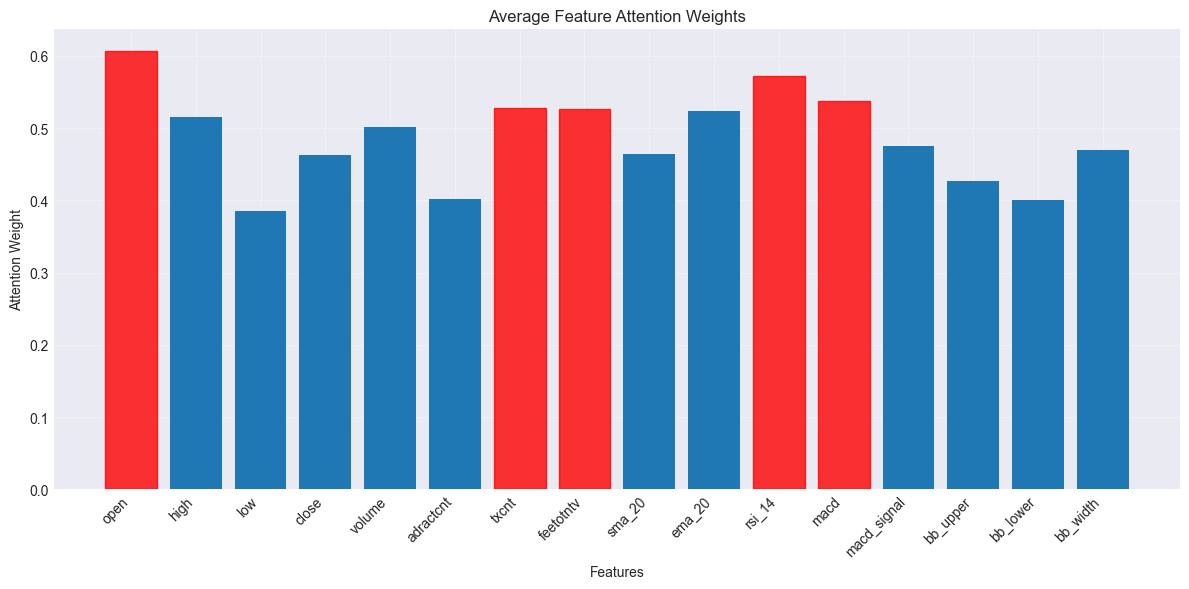

Top 5 most important features:
1. open: 0.6064
2. rsi_14: 0.5724
3. macd: 0.5375
4. txcnt: 0.5279
5. feetotntv: 0.5269


In [31]:
analyze_attention_weights(results['model'], 
    val_loader, 
    feature_names=feature_cols, 
    num_samples=10
)

In [ ]:
from sklearn.base import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error


def make_predictions(model, data_loader, scaler=None, return_attention=False):
    """
    Generate predictions from trained model
    
    Args:
        model: Trained CNN-LSTM model
        data_loader: DataLoader with test/validation data
        scaler: Scaler used to normalize target values (for inverse transform)
        return_attention: Whether to return attention weights
    
    Returns:
        predictions, actual_values, attention_weights (optional)
    """
    model.eval()
    predictions = []
    actual_values = []
    attention_weights_list = []
    
    print("Generating predictions...")
    
    with torch.no_grad():
        for batch_idx, (batch_X, batch_y) in enumerate(data_loader):
            if return_attention:
                outputs, attention_weights = model(batch_X, return_attention_weights=True)
                attention_weights_list.append(attention_weights)
            else:
                outputs = model(batch_X)
            
            predictions.extend(outputs.cpu().numpy().flatten())
            actual_values.extend(batch_y.cpu().numpy().flatten())
            
            # Show progress
            if batch_idx % 10 == 0:
                print(f"  Processed {batch_idx + 1}/{len(data_loader)} batches")
    
    predictions = np.array(predictions)
    actual_values = np.array(actual_values)
    
    # Inverse transform if scaler provided
    if scaler is not None:
        predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        actual_values = scaler.inverse_transform(actual_values.reshape(-1, 1)).flatten()
    
    print(f"Generated {len(predictions)} predictions")
    
    if return_attention:
        return predictions, actual_values, attention_weights_list
    return predictions, actual_values


def calculate_metrics(actual, predicted):
    """
    Calculate comprehensive prediction metrics
    """
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    
    # Financial metrics
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    # Directional accuracy (did we predict the right direction?)
    actual_direction = np.sign(np.diff(actual))
    predicted_direction = np.sign(np.diff(predicted))
    directional_accuracy = np.mean(actual_direction == predicted_direction) * 100
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'Directional_Accuracy': directional_accuracy
    }


def plot_predictions_overview(actual, predicted, dates=None, title="Bitcoin Price Predictions"):
    """
    Create comprehensive prediction visualization
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # 1. Time series plot
    ax1 = axes[0, 0]
    if dates is not None:
        ax1.plot(dates, actual, label='Actual Price', color='blue', alpha=0.8, linewidth=2)
        ax1.plot(dates, predicted, label='Predicted Price', color='red', alpha=0.8, linewidth=2)
    else:
        x = range(len(actual))
        ax1.plot(x, actual, label='Actual Price', color='blue', alpha=0.8, linewidth=2)
        ax1.plot(x, predicted, label='Predicted Price', color='red', alpha=0.8, linewidth=2)
    
    ax1.set_title('Actual vs Predicted Prices Over Time')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Bitcoin Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Scatter plot
    ax2 = axes[0, 1]
    ax2.scatter(actual, predicted, alpha=0.6, color='purple')
    min_val = min(min(actual), min(predicted))
    max_val = max(max(actual), max(predicted))
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
    ax2.set_xlabel('Actual Price ($)')
    ax2.set_ylabel('Predicted Price ($)')
    ax2.set_title('Prediction Accuracy Scatter Plot')
    ax2.grid(True, alpha=0.3)
    
    # 3. Error distribution
    ax3 = axes[1, 0]
    errors = predicted - actual
    ax3.hist(errors, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax3.axvline(x=0, color='red', linestyle='--', alpha=0.8)
    ax3.set_xlabel('Prediction Error ($)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Prediction Errors')
    ax3.grid(True, alpha=0.3)
    
    # 4. Recent predictions zoom
    ax4 = axes[1, 1]
    recent_n = min(100, len(actual))  # Last 100 predictions
    recent_actual = actual[-recent_n:]
    recent_predicted = predicted[-recent_n:]
    recent_x = range(len(recent_actual))
    
    ax4.plot(recent_x, recent_actual, label='Actual', color='blue', linewidth=2, marker='o', markersize=3)
    ax4.plot(recent_x, recent_predicted, label='Predicted', color='red', linewidth=2, marker='s', markersize=3)
    ax4.set_title(f'Recent {recent_n} Predictions (Zoomed)')
    ax4.set_xlabel('Time Steps')
    ax4.set_ylabel('Price ($)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def create_prediction_dataframe(actual, predicted, dates=None):
    """
    Create a detailed DataFrame with predictions and analysis
    """
    df = pd.DataFrame({
        'Actual_Price': actual,
        'Predicted_Price': predicted,
        'Error': predicted - actual,
        'Absolute_Error': np.abs(predicted - actual),
        'Percentage_Error': ((predicted - actual) / actual) * 100
    })
    
    if dates is not None:
        df['Date'] = dates
        df = df[['Date', 'Actual_Price', 'Predicted_Price', 'Error', 'Absolute_Error', 'Percentage_Error']]
    
    # Add directional indicators
    df['Actual_Direction'] = np.nan
    df['Predicted_Direction'] = np.nan
    df['Direction_Correct'] = np.nan
    
    if len(df) > 1:
        df.loc[1:, 'Actual_Direction'] = np.sign(df['Actual_Price'].diff()[1:])
        df.loc[1:, 'Predicted_Direction'] = np.sign(df['Predicted_Price'].diff()[1:])
        df.loc[1:, 'Direction_Correct'] = (df['Actual_Direction'][1:] == df['Predicted_Direction'][1:])
    
    return df


def analyze_predictions_by_timeframe(df, price_col='Actual_Price', pred_col='Predicted_Price'):
    """
    Analyze prediction performance by different timeframes
    """
    if 'Date' not in df.columns:
        print("⚠️  No date information available for timeframe analysis")
        return
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['Month'] = df['Date'].dt.to_period('M')
    df['Week'] = df['Date'].dt.to_period('W')
    
    # Monthly analysis
    monthly_metrics = []
    for month in df['Month'].unique():
        month_data = df[df['Month'] == month]
        if len(month_data) > 1:
            metrics = calculate_metrics(month_data[price_col], month_data[pred_col])
            metrics['Period'] = str(month)
            metrics['Type'] = 'Monthly'
            monthly_metrics.append(metrics)
    
    if monthly_metrics:
        monthly_df = pd.DataFrame(monthly_metrics)
        print("\nMonthly Performance Analysis:")
        print(monthly_df[['Period', 'RMSE', 'MAE', 'MAPE', 'Directional_Accuracy']].to_string(index=False))


def show_worst_and_best_predictions(df, n=10):
    """
    Show the worst and best predictions
    """
    print(f"\n{n} Worst Predictions (Highest Absolute Error):")
    worst = df.nlargest(n, 'Absolute_Error')
    print(worst[['Date', 'Actual_Price', 'Predicted_Price', 'Error', 'Percentage_Error']].to_string(index=False))
    
    print(f"\n{n} Best Predictions (Lowest Absolute Error):")
    best = df.nsmallest(n, 'Absolute_Error')
    print(best[['Date', 'Actual_Price', 'Predicted_Price', 'Error', 'Percentage_Error']].to_string(index=False))


def comprehensive_prediction_analysis(model, test_loader, dates=None, scaler=None, 
                                    feature_names=None, save_results=True):
    """
    Complete analysis of model predictions
    """
    print("🚀 Starting Comprehensive Prediction Analysis")
    print("=" * 60)
    
    # Generate predictions
    predictions, actual_values, attention_weights = make_predictions(
        model, test_loader, scaler, return_attention=True
    )
    
    # Calculate metrics
    metrics = calculate_metrics(actual_values, predictions)
    
    print("\nPrediction Metrics:")
    print("-" * 30)
    for metric, value in metrics.items():
        if metric == 'Directional_Accuracy':
            print(f"  {metric}: {value:.2f}%")
        elif metric in ['MAPE']:
            print(f"  {metric}: {value:.2f}%")
        elif metric in ['R2']:
            print(f"  {metric}: {value:.4f}")
        else:
            print(f"  {metric}: ${value:,.2f}")
    
    # Create detailed DataFrame
    df = create_prediction_dataframe(actual_values, predictions, dates)
    
    # Show sample predictions
    print(f"\nSample Predictions (First 10):")
    print(df.head(10)[['Date', 'Actual_Price', 'Predicted_Price', 'Error', 'Percentage_Error']].to_string(index=False))
    
    # Show best and worst predictions
    show_worst_and_best_predictions(df, n=5)
    
    # Timeframe analysis
    analyze_predictions_by_timeframe(df)
    
    # Create visualizations
    plot_predictions_overview(actual_values, predictions, dates, 
                            title="Bitcoin Price Prediction Analysis")
    
    # Analyze attention weights if available
    if attention_weights and feature_names:
        analyze_feature_attention(attention_weights, feature_names)
    
    # Save results
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"bitcoin_predictions_{timestamp}.csv"
        df.to_csv(filename, index=False)
        print(f"\nResults saved to: {filename}")
    
    return df, metrics


def analyze_feature_attention(attention_weights_list, feature_names):
    """
    Analyze and visualize feature attention weights
    """
    if not attention_weights_list or 'feature_attention' not in attention_weights_list[0]:
        print("No feature attention weights available")
        return
    
    # Extract feature attention weights
    feature_attentions = []
    for weights in attention_weights_list:
        if 'feature_attention' in weights:
            feature_attentions.append(weights['feature_attention'].cpu().numpy())
    
    if not feature_attentions:
        return
    
    # Calculate average attention weights
    avg_attention = np.mean(np.vstack(feature_attentions), axis=0)
    
    # Create DataFrame
    attention_df = pd.DataFrame({
        'Feature': feature_names[:len(avg_attention)],
        'Attention_Weight': avg_attention
    }).sort_values('Attention_Weight', ascending=False)
    
    print(f"\nFeature Importance (Top 10):")
    print(attention_df.head(10).to_string(index=False))
    
    # Plot feature attention
    plt.figure(figsize=(12, 8))
    bars = plt.bar(range(len(avg_attention)), avg_attention)
    plt.xlabel('Features')
    plt.ylabel('Attention Weight')
    plt.title('Feature Attention Weights - What the Model Focuses On')
    plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
    
    # Highlight top 5 features
    top_indices = np.argsort(avg_attention)[-5:]
    for i in top_indices:
        bars[i].set_color('red')
        bars[i].set_alpha(0.8)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()




In [34]:
# Convert to PyTorch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1) # Reshape y_train to be 2D (batch_size, 1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoaders
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=32, shuffle=False)


In [36]:
test_dates = df.index[train_size + val_size + window_size:]

🚀 Starting Comprehensive Prediction Analysis
🔮 Generating predictions...
  Processed 1/2 batches
✅ Generated 44 predictions

📊 Prediction Metrics:
------------------------------
  MSE: $0.01
  RMSE: $0.09
  MAE: $0.08
  R2: -3.5600
  MAPE: 8.28%
  Directional_Accuracy: 41.86%

🔍 Sample Predictions (First 10):
      Date  Actual_Price  Predicted_Price     Error  Percentage_Error
2025-05-16      0.857675         0.816213 -0.041462         -4.834179
2025-05-17      0.851807         0.824061 -0.027747         -3.257381
2025-05-18      0.909142         0.831434 -0.077708         -8.547390
2025-05-19      0.894304         0.840084 -0.054219         -6.062747
2025-05-20      0.916235         0.849479 -0.066757         -7.285979
2025-05-21      0.964984         0.852246 -0.112737        -11.682802
2025-05-22      1.000000         0.854011 -0.145989        -14.598888
2025-05-23      0.923962         0.855071 -0.068890         -7.455985
2025-05-24      0.932000         0.853801 -0.078199        

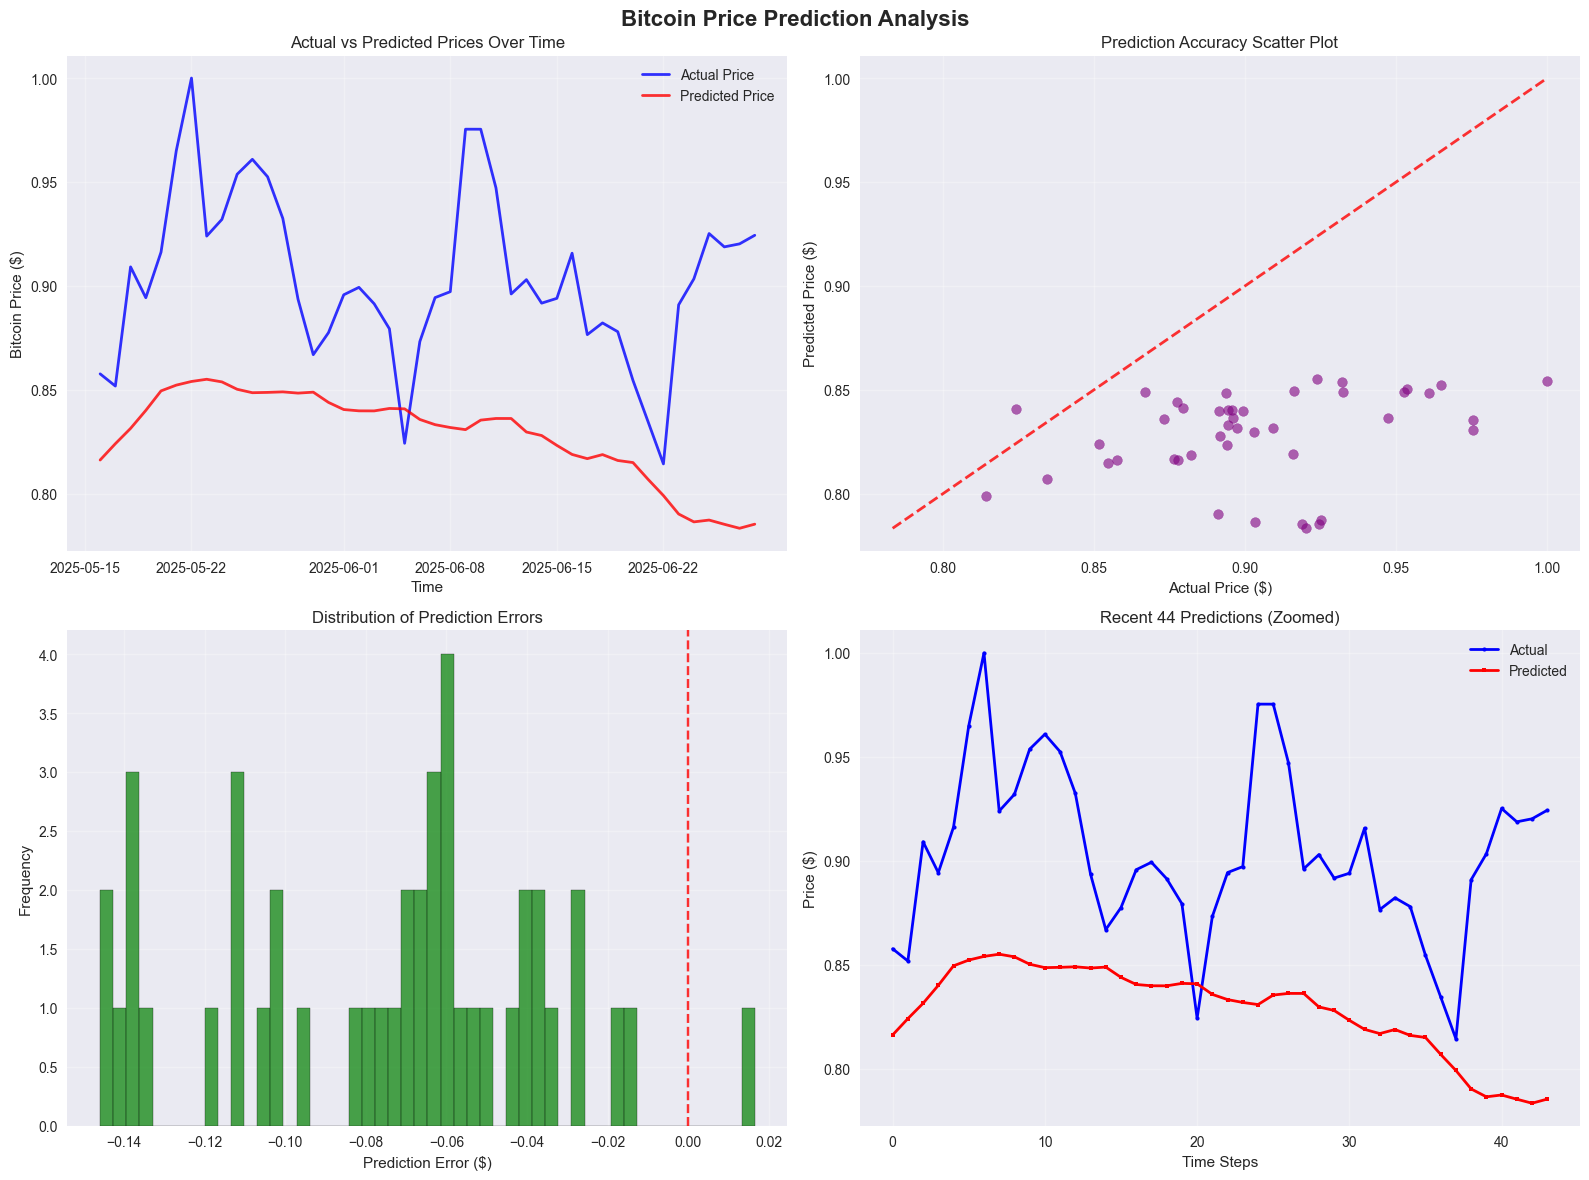


🎯 Feature Importance (Top 10):
    Feature  Attention_Weight
       open          0.607583
     rsi_14          0.573081
       macd          0.563931
     ema_20          0.547636
      txcnt          0.539206
  feetotntv          0.519565
       high          0.517301
macd_signal          0.489388
     volume          0.484336
   bb_width          0.483074


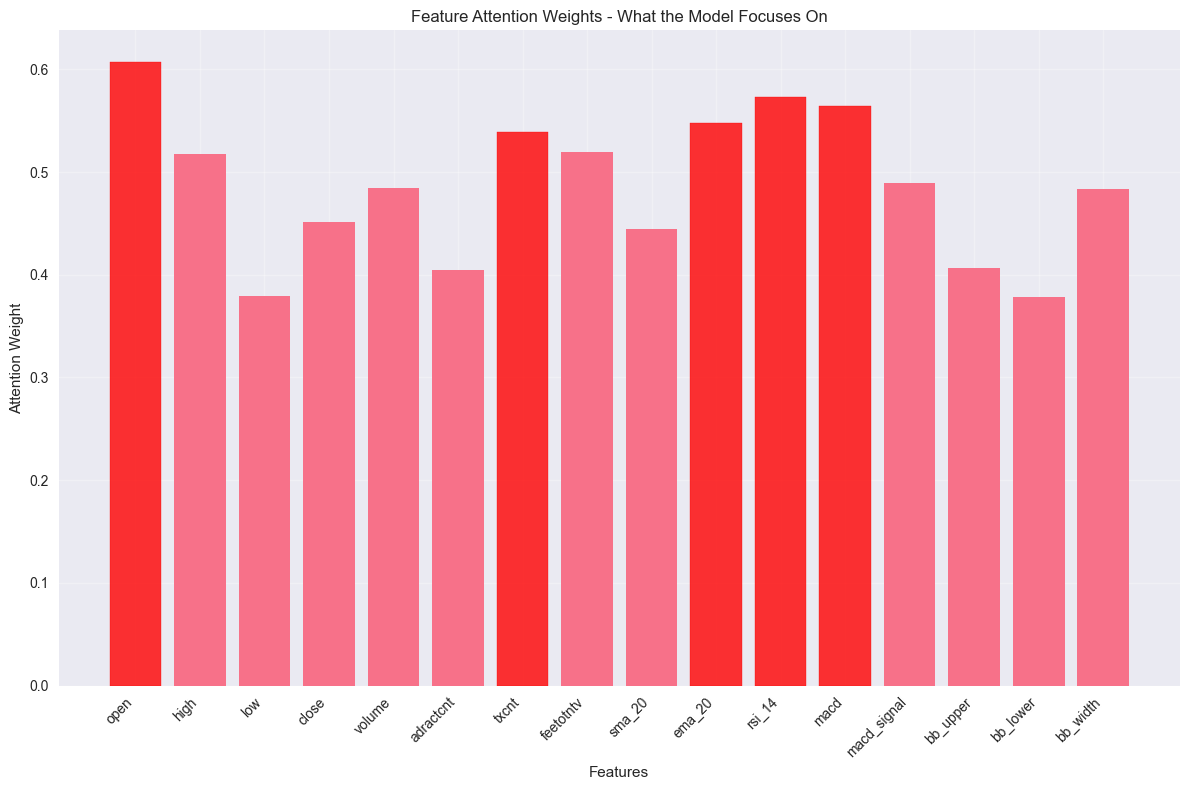


💾 Results saved to: bitcoin_predictions_20250629_222546.csv

🎉 Analysis Complete!


In [37]:
# Analyze your trained model's predictions
results_df, metrics = comprehensive_prediction_analysis(
    model=model,  # Your trained model
    test_loader=test_loader,  # Your test data
    dates=test_dates,  # Optional: dates for each prediction
    feature_names=feature_cols,  # Your feature column names
    save_results=True  # Saves detailed CSV file
)